### 環境初始化

In [1]:
cd /home/kk/jupyter/mouth_detection/

/home/kk/jupyter/mouth_detection


In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import json
import random
%matplotlib inline

Using TensorFlow backend.


### 資料集格式範例


檔案標頭
```json
{
    "file": "1-FemaleNoGlasses-Normal",
    "size": 419,
    "fps": 30,
    "marker_path": "dataset/markers/1-FemaleNoGlasses-Normal.csv",
    "video_path": "dataset/YawDD/train/1-FemaleNoGlasses-Normal.avi"
}
```
標記內容
```json
{
    "index": 1,
    "level": "0",
    "mouth_ear": 0.02305602969572012,
    "roll": -2.8421378836556643,
    "yaw": 38.241611421108246,
    "pitch": -11.410418897867203
}
```

### 功能函式

**自訂功能函式**：map(var, in_min, in_max, out_min, out_max)

In [3]:
def map(var, in_min, in_max, out_min, out_max):
    var = float(var)
    if var >= in_max:
        return out_max
    if var <= in_min:
        return out_min
    return (var - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

**讀取資料集且正規化**：readData(file)

In [4]:
def readDataList(file):
    train_list = []
    with open(file, 'r', encoding='utf-8') as f:
        while True:
            line = f.readline()
            if len(line) == 0: break
            file_json = json.loads(line)
            mlist = []
            for i in range(file_json['size']):
                mline = f.readline()
                mjson = json.loads(mline)
                level = map(mjson['level'], 0, 5, 0, 1)
                mouth_ear = map(mjson['mouth_ear'], 0, 1, 0, 1)
                roll = map(mjson['roll'], -50, 50, -1, 1)
                yaw = map(mjson['yaw'], -50, 50, -1, 1)
                pitch = map(mjson['pitch'], -50, 50, -1, 1)
                mlist.append(np.array([
                    level,
                    mouth_ear,
                    roll,
                    yaw,
                    pitch
                ]))
            train_list.append(np.array(mlist))
    return np.array(train_list)

**產生訓練資料**：buildTrain(train_list, long=300)

In [5]:
def buildTrain(train_list, long=300):
  X_train, Y_train = [], []
  for t in train_list:
    train = np.array(t)
    for i in range(train.shape[0]-long):
      X_train.append(train[i:i+long,1:])
      Y_train.append(train[i+long-1][0])
  return np.array(X_train), np.array(Y_train)

**資料隨機排序**：shuffle(X,Y)

In [6]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

**產生驗證資料**：splitData(X, Y, rate)

In [7]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

### 主程式

##### 建立訓練資料

In [8]:
train_list = readDataList('train_data.txt')
X_train, Y_train = buildTrain(train_list, 300)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

**訓練資料圖形化**

X_data = [98632,:,0], Y_data = 0.8


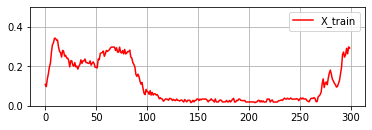

X_data = [9572,:,0], Y_data = 0.0


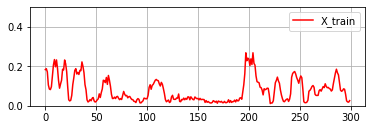

In [9]:
def drawTrain(i, num):
    plt.subplot(210 + i)
    plt.plot(X_train[num,:,0], color='r', label='X_train')
    print(f'X_data = [{num},:,0], Y_data = {Y_train[num]}')
    plt.ylim(0, 0.5)
    plt.legend()
    plt.grid(True)
    plt.show()
def getRnd():
    return random.randint(0, X_train.shape[0] - 1)
def draw():
    while True:
        rnd = getRnd()
        if Y_train[rnd] > 0.5:
            drawTrain(1, rnd)
            break
    while True:
        rnd = getRnd()
        if Y_train[rnd] <= 0.5:
            drawTrain(2, rnd)
            break
draw()

##### 建立訓練模型

In [10]:
model = Sequential([
    LSTM(50, return_sequences = True, input_shape=X_train.shape[1:]),
    Dropout(0.2),
    LSTM(50, return_sequences = True),
    Dropout(0.2),
    LSTM(50, return_sequences = True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss="mse", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300, 50)           11000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 50)           20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

**查看模型權重**

In [ ]:
print(len(model.layers))
print(model.layers[0].get_weights())

##### 開始訓練

In [11]:
epochs = 1000
batch_size = 32
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
trainHistory = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[callback])

Train on 114966 samples, validate on 12773 samples
Epoch 1/1000
114966/114966 [==============================] - 4841s 42ms/step - loss: 0.0272 - val_loss: 0.0320
Epoch 2/1000
114966/114966 [==============================] - 5095s 44ms/step - loss: 0.0251 - val_loss: 0.0182
Epoch 3/1000
114966/114966 [==============================] - 5359s 47ms/step - loss: 0.0173 - val_loss: 0.0134
Epoch 4/1000
114966/114966 [==============================] - 5431s 47ms/step - loss: 0.0149 - val_loss: 0.0166
Epoch 5/1000
114966/114966 [==============================] - 5460s 47ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 6/1000
114966/114966 [==============================] - 5469s 48ms/step - loss: 0.0111 - val_loss: 0.0126
Epoch 7/1000
114966/114966 [==============================] - 5460s 47ms/step - loss: 0.0109 - val_loss: 0.0093
Epoch 8/1000
114966/114966 [==============================] - 5428s 47ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 9/1000
114966/114966 [=========================

**繪製Loss線**

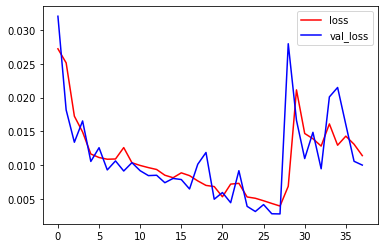

In [13]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

### 匯出模型

In [ ]:
model_file_name = f'model_{len(model.layers)}_layer_{epochs}_epoch_{batch_size}_batch.h5'
model_file_name

In [ ]:
model.save(model_file_name)

# 測試模型

In [ ]:
from keras.models import load_model
my_model = load_model(model_file_name)

In [ ]:
test = readData('output2.txt')
test_norm = normalize(test)
X_test, Y_test = buildTrain(test_norm, 100)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(f'X_test: {X_test.shape}')
print(f'Y_test: {Y_test.shape}')

In [ ]:
predicted = my_model.predict(X_test)
plt.plot(test_norm[100:,1], color='g', label='X_test')
plt.plot(Y_test, color='r', label='Y_test')
plt.plot(predicted, color='b', label='Predicted')
plt.legend()
plt.show()